*Boilerplate de importações necessárias*

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
print(cv2.__version__)
import os

#Pop-up do Matplotlib
#%matplotlib qt

#Exibição na mesma tela do Jupyter
%matplotlib inline

#plt.rcParams["figure.figsize"]\
#(8,5)

from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL

import datetime


plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

3.4.2


# Face média da turma 😄

Geração de face média com base nas fotos os alunos do curso, separado por sexo. A ideia deste experimento é evidenciar um pouco sobre como o método de classificação de faces **Eingen Faces** utiliza uma face média para estabelecer aproximações por similaridade.

Para tornar mais preciso, utilizamos uma extração de faces por classificador em cascata de Haar como etapa de normalização inicial.

Nosso dataset se encontra no diretório "eigen-faces". Os arquivos iniciados por h são dos homens e os iniciados por m são das mulheres.

Este código foi adaptado deste [artigo](https://www.learnopencv.com/eigenface-using-opencv-c-python/) de Satya Mallick. O repositório original se encontra neste [link](https://github.com/spmallick/learnopencv/blob/master/EigenFace/EigenFace.py).

In [2]:
# Read images from the directory
def readImages(path, gender):
     
    classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')
    
    # Create array of array of images.
    images = []
    
    # List all files in the directory and read points from text files one by one
    for filePath in sorted(os.listdir(path)):
        fileExt = os.path.splitext(filePath)[1]
        
        f = 0
            
        if fileExt in [".jpg", ".jpeg"]:
            if gender == "h":
                if not filePath.startswith("h"):
                    continue
            else:
                if not filePath.startswith("m"):
                    continue

            # Add to array of images
            imagePath = os.path.join(path, filePath)            
            im = cv2.imread(imagePath)
            im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            face = classificador_face.detectMultiScale(im_gray, 1.3, 3)
            
            for (x,y,w,h) in face:
                roi = im[y:y+h, x:x+w]
                
                if len(roi) == 0:
                    continue
                
                roi = cv2.resize(roi, (100,100))
                im = np.float32(roi)/255.0
                images.append(im)
                imFlip = cv2.flip(im, 1);
                images.append(imFlip)
            
            if face is ():
                print(imagePath)
    
    numImages = int(len(images) / 2)
    print(str(numImages) + " files read.")
    
    return images

In [3]:
def createDataMatrix(images):
    print("Creating data matrix",end=" ... ")

    ''' 
    Allocate space for all images in one data matrix.
    The size of the data matrix is
    ( w  * h  * 3, numImages )
    where,
    w = width of an image in the dataset.
    h = height of an image in the dataset.
    3 is for the 3 color channels.
    '''

    numImages = len(images)
    print(numImages)
    
    sz = images[0].shape
    print(sz)
    
    data = np.zeros((numImages, sz[0] * sz[1] * sz[2]), dtype=np.float32)
    for i in range(0, numImages):
        image = images[i].flatten()
        data[i,:] = image
    
    return data

# Realizando um teste com as faces masculinas da turma.

eingen-faces/7ia/h_334483.jpg
eingen-faces/7ia/h_335064.jpg
38 files read.
2 files read.
33 files read.
7 files read.
39 files read.
3 files read.
40 files read.
4 files read.
Creating data matrix ... 332
(100, 100, 3)
Processando PCA ...Terminado


Text(0.5,1,'Face Média')

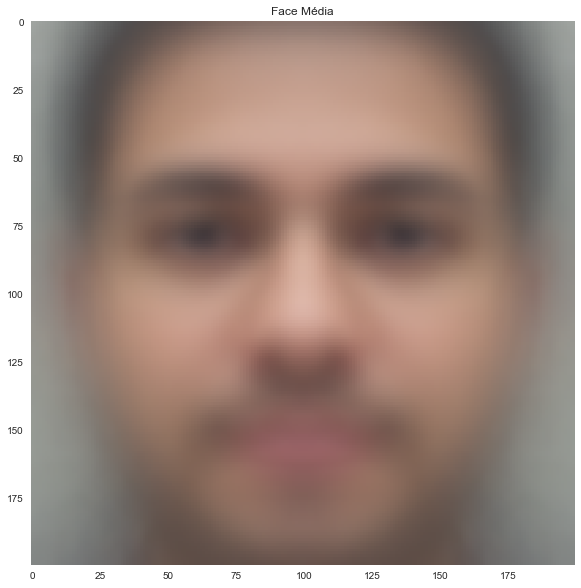

In [4]:
#Carrendo imagens de cada turma
images_7h = readImages("eingen-faces/7ia", "h")
images_7m = readImages("eingen-faces/7ia", "m")

images_6h = readImages("eingen-faces/6ia", "h")
images_6m = readImages("eingen-faces/6ia", "m")

images_3h = readImages("eingen-faces/3ia", "h")
images_3m = readImages("eingen-faces/3ia", "m")

images_4h = readImages("eingen-faces/4ia", "h")
images_4m = readImages("eingen-faces/4ia", "m")

# Juntando todas as imagens para calcular face geral
images = images_7h + images_7m
images += images_6h + images_6m
images += images_4h + images_4m
images += images_3h + images_3m

# Juntando todas as imagens para calcular face de homens
images_h = images_7h 
images_h += images_3h 
images_h += images_4h
images_h += images_6h

# Juntando todas as imagens para calcular face de mulheres
images_m = images_7m
images_m += images_3m 
images_m += images_4m
images_m += images_6m

# Mariz para cálculo do PCA
data = createDataMatrix(images)

# Cálculo dos Eingen Vectores
print("Processando PCA ", end="...")
mean, eigenVectors = cv2.PCACompute(data, mean=None)
print("Terminado")

sz = images[0].shape
averageFace = mean.reshape(sz)

# Saída
output = cv2.resize(averageFace, (0,0), fx=2, fy=2)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(output)
plt.title("Face Média")

Incorporando em uma função para poder alterar entre masculino e feminino.

In [5]:
def get_mean_face(path, gender):
    images = readImages(path, gender)

    sz = images[0].shape

    data = createDataMatrix(images)
    mean, eigenVectors = cv2.PCACompute(data, mean=None)
    
    eigenFaces = []
    
    for eigenVector in eigenVectors:
        eigenFace = eigenVector.reshape(sz)
        eigenFaces.append(eigenFace)

    averageFace = mean.reshape(sz)
    output = cv2.cvtColor(averageFace, cv2.COLOR_BGR2RGB)
    
    return output, eigenFaces

Essa função recebe uma lista de imagens e retorna a face média e os eingen vectors.

In [6]:
def get_mean_face_images(images):
    sz = images[0].shape

    data = createDataMatrix(images)
    mean, eigenVectors = cv2.PCACompute(data, mean=None)
    
    eigenFaces = []
    
    for eigenVector in eigenVectors:
        eigenFace = eigenVector.reshape(sz)
        eigenFaces.append(eigenFace)

    averageFace = mean.reshape(sz)
    output = cv2.cvtColor(averageFace, cv2.COLOR_BGR2RGB)
    
    return output, eigenFaces

Creating data matrix ... 332
(100, 100, 3)
Creating data matrix ... 300
(100, 100, 3)
Creating data matrix ... 32
(100, 100, 3)


Text(0.5,1,'Face Média Mulher')

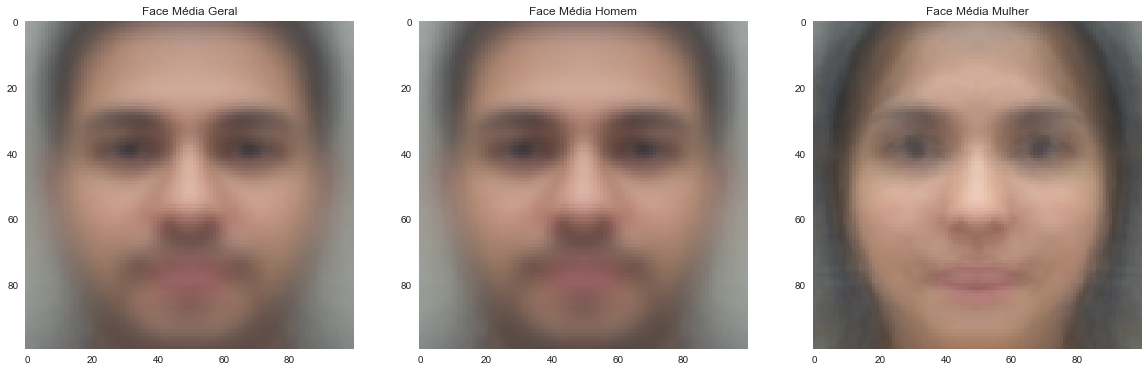

In [11]:
face_media_geral, _ = get_mean_face_images(images)
face_media_homem, _ = get_mean_face_images(images_h)
face_media_mulher, _ = get_mean_face_images(images_m)

plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(face_media_geral)
plt.title("Face Média Geral")

plt.subplot(1,3,2)
plt.imshow(face_media_homem)
plt.title("Face Média Homem")

plt.subplot(1,3,3)
plt.imshow(face_media_mulher)
plt.title("Face Média Mulher")

Creating data matrix ... 80
(100, 100, 3)
Creating data matrix ... 66
(100, 100, 3)
Creating data matrix ... 14
(100, 100, 3)


Text(0.5,1,'Face Média Mulher')

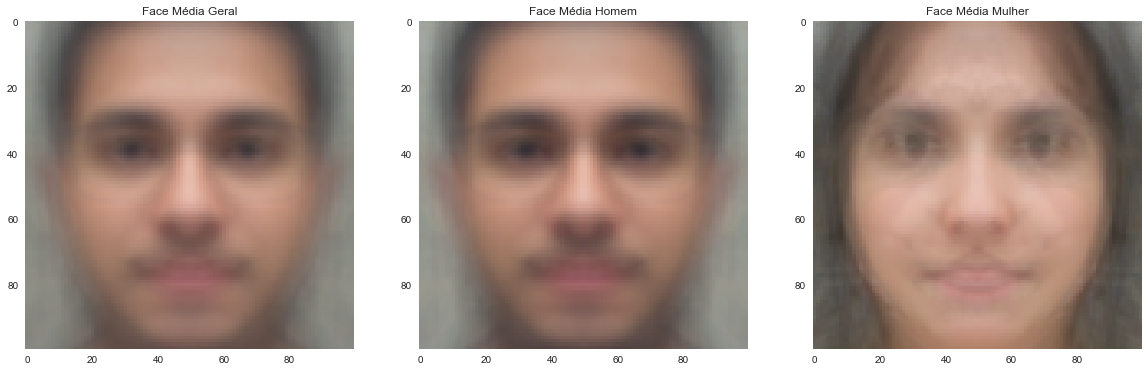

In [12]:
face_media_geral, _ = get_mean_face_images(images_6h + images_6m)
face_media_homem, _ = get_mean_face_images(images_6h)
face_media_mulher, _ = get_mean_face_images(images_6m)

plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(face_media_geral)
plt.title("Face Média Geral")

plt.subplot(1,3,2)
plt.imshow(face_media_homem)
plt.title("Face Média Homem")

plt.subplot(1,3,3)
plt.imshow(face_media_mulher)
plt.title("Face Média Mulher")

Navegando nos pesos dos componentes principais (PCA), é possível reconstruir novos rostos a partir do espaço de faces criado pelos eingen faces.

Experimente incluir pesos positivos ou negativos, por exemplo -20, -10, 0 (é a média), 10, 20.

In [13]:
def createNewFace(averageFace, weight, eingenface, eigenFaces):
    output = averageFace
    output = np.add(output, eigenFaces[eingenface] * weight)
    output = cv2.resize(output, (0,0), fx=2, fy=2)
    return output

In [14]:
face_media, eingenFaces = get_mean_face_images(images)

Creating data matrix ... 332
(100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Nova face masculina')

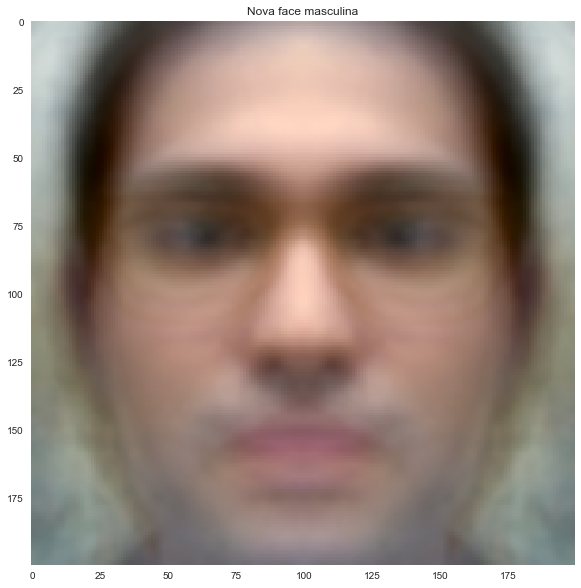

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(createNewFace(face_media, 20, 8, eingenFaces))
plt.title("Nova face masculina")

In [18]:
face_media_mulher, eigenFaces = get_mean_face("eingen-faces/7ia", "m")

2 files read.
Creating data matrix ... 4
(100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Face Média Mulher')

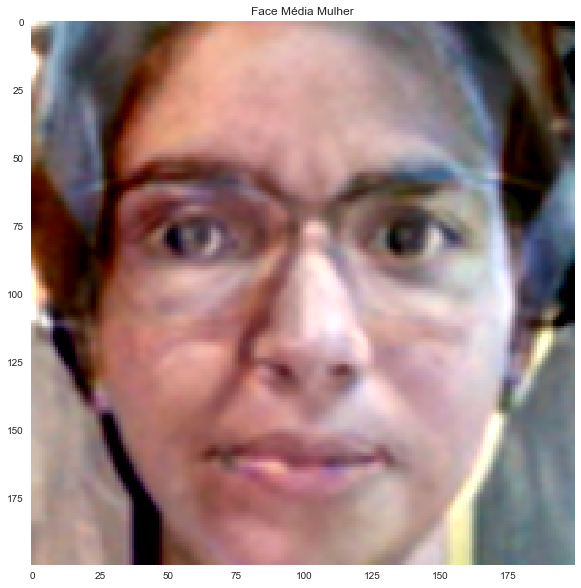

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(createNewFace(face_media_mulher, 30, -2, eigenFaces))
plt.title("Face Média Mulher")